# 1. Introduction and Hypothesis 

Using long historical texts (i.e., novels) to learn data science for the humanities provided many insights throughout the semester. However, our group was quite interested by the social media data that we discussed towards the end of the semester because a lot of meaning can be derived from short texts (e.g., Tweets, posts, etc.). We were also interested by the dynamic nature of this data. In order to balance the ethical and processing concerns of social media data, we decided to look at Yelp restaurant reviews as a way to analyze "medium length" text data. We were also interested in Yelp reviews because they correspond directly to a number rating (1-5 stars) that the user writing the review determines. Because everyone has a subjective understanding of a star rating, we thought this could pose some interesting challenges when analyzing this data.

**Research Question & Hypothesis**

How accurately can various algorithms correctly classify star rating based on review text?
What NLP method is most effective for identifying star numbers based on review text?
- Tf-idf Lemma feature matrices?
- Average review sentiment feature matrix?

How accurately can topic modeling paired with various algorithms identify what type of restaurant a review is written about?
- Restaurant vs other type of business?
- Specific types of restaurants in a multiclass classification?
- Specific types of restaurants in single item classification (Mexican or not)?

Our hypothesis for the first two questions was that given the opinionated nature of reviews, both lemma feature matrices as well as sentiment score feature matrices would be able to classify reviews into star levels much better than baseline accuracy. We were less convinced that topic modelling would successfully reveal restaurant cuisines, because often reviews just say things like "Great service, and the food was really tasty! We will be back soon." which does not include any information on the type of food served at the restaurant. We hypothesized that a binary cuisine classifier would perform much better than a multiclass cuisine question because the small number of cuisine-specific topics would be weighted heavily for the cuisine-specific reviews.

***NOTE: Our results are presented throughout the body section, so our "Results" section is a shorter summary of our findings.***

# 2. Data and Methods 

Our data is sourced directly from [Yelp](yelp.com). The original dataset has 7 million customer reviews for restaurants and stores. Each row in the reviews dataset has:
- review text
- 1-5 star rating
- 'useful 'cool' and 'funny' votes on the review
- user, business, and review ids for joining among the user, business, and review tables they publish. We joined the review table with the businesses table for our attempt at classifying restaurants later in this notebook.

The businesses dataset has:
- Business name
- Business ID
- Business location information
- Business hours
- Business category list
- Average Star Rating
- Total Reviews

Originally, we sourced 7 million reviews from Yelp which they make available in json format. Then we ran a .py script (submitted along with this project which we found in a github repository built to help process this Yelp data, and then slightly modified for our needs) to convert the json into a csv, because loading in a random subset of the json was taking excessively long in jupyter lab. Next, in a previous notebook (submitted along with this project) we randomly selected 14,997 (approx 15,000) reviews, and saved them into a separate file, called selected_yelp_reviews.csv.

Our entire project relies on classification using different feature matrix methods. We use lemmatized tokens, sentiment scores, and topic models to answer different classification questions based on different subsets of the data.

In [1]:
import os
import random
import requests
import spacy
import string
import math
import pathlib
import unicodedata
import copy
import re
import warnings
import pickle

import numpy as np
import pandas as pd
import seaborn as sns

from   glob import glob
from   nltk import word_tokenize, sent_tokenize
from   nltk.corpus import stopwords
from   collections import Counter, defaultdict
from   matplotlib import pyplot as plt

from   sklearn.feature_extraction import DictVectorizer
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.feature_extraction.text import CountVectorizer
from   sklearn.feature_selection import SelectKBest, mutual_info_regression
from   sklearn.linear_model import LinearRegression, LogisticRegression
from   sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from   sklearn.preprocessing import StandardScaler
from   sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, precision_score, accuracy_score
from   sklearn.cluster import KMeans, SpectralClustering, DBSCAN, OPTICS, AgglomerativeClustering
from   sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from   sklearn.decomposition import TruncatedSVD
from   sklearn.tree import DecisionTreeClassifier
from   sklearn.ensemble import RandomForestClassifier
from   sklearn.naive_bayes import MultinomialNB
from   sklearn.decomposition import LatentDirichletAllocation
from   sklearn.neighbors import KNeighborsClassifier
from   sklearn.dummy import DummyClassifier

In [2]:
reviews = pd.read_csv('selected_yelp_reviews.csv')
reviews.head()

,user_id,useful,review_id,cool,stars,text,date,funny,business_id
0,M3xME4pvnOYi06q2upH3vw,0,pEwlvpFtLSoYok1i9F0Tew,0,4.0,It's a nice place. Really nice! Great service ...,2012-07-16 01:31:26,0,M0c99tzIJPIbrY_RAO7KSQ
1,VbGus5yJEza4G0blt2sPqA,0,oSWY_2X9CApWlJrN0TsA6Q,0,5.0,My go to place in IN when visiting family! Da...,2016-06-11 20:19:32,0,Q8q-1MZTYPL9ZBmAeoMKVg
2,n0zPBuXxQuxHOQmA4ehcvQ,0,iOQ_bnKI5HfPbH43DMAw6w,0,3.0,This place is good. For the lofty prices the p...,2013-01-27 19:22:26,0,YtSqYv1Q_pOltsVPSx54SA
3,J2nuqbMp9ooEa_0QD9kjvg,0,qO--SRLwiNfGGKAPeSGHpA,0,5.0,"For a $16 haircut, I was expecting an OK-looki...",2011-08-26 01:37:56,0,eaV07HGOcyb27XobHVl8LQ
4,X23bt-XPgRC5yqtrSgp9Jg,3,i7CqIbvjgr6M8qGuyOV98g,1,1.0,I wish I had read the other reviews before set...,2012-03-01 20:14:15,0,-pgTW7620zWdXMOczX0www


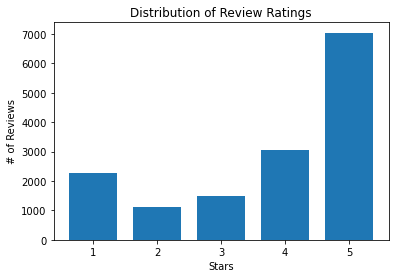

In [3]:
# graph initial rating distribution
plt.hist(reviews['stars'], bins=[1,2,3,4,5,6], align='left', rwidth=0.75)
plt.xlabel('Stars')
plt.ylabel('# of Reviews')
plt.title("Distribution of Review Ratings")
plt.show()

### As we can see here, the target variable (star rating) has very imbalanced classes, ranging from 1,000 2-star reviews to 7,000 5-star reviews. This may result in a bias toward 5-star reviews and against 2-star reviews in our classifiers.

In [4]:
# load business dataset
businesses = pd.read_json("yelp_academic_dataset_business.json", lines=True)

#combine with reviews metadata
combined = reviews.merge(businesses, on='business_id', how='left')

# drop row with no categories
combined = combined.drop(9777)

In [5]:
combined.head()

,user_id,useful,review_id,cool,stars_x,text,date,funny,business_id,name,...,state,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours
0,M3xME4pvnOYi06q2upH3vw,0,pEwlvpFtLSoYok1i9F0Tew,0,4.0,It's a nice place. Really nice! Great service ...,2012-07-16 01:31:26,0,M0c99tzIJPIbrY_RAO7KSQ,Hyatt Regency St. Louis at the Arch,...,MO,63102,38.626221,-90.187770,3.5,430,1,"{'WiFi': 'u'free'', 'BusinessAcceptsCreditCard...","Event Planning & Services, Venues & Event Spac...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
1,VbGus5yJEza4G0blt2sPqA,0,oSWY_2X9CApWlJrN0TsA6Q,0,5.0,My go to place in IN when visiting family! Da...,2016-06-11 20:19:32,0,Q8q-1MZTYPL9ZBmAeoMKVg,Lilly Nails & Spa,...,IN,46038,39.956701,-86.023032,4.0,68,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Beauty & Spas, Nail Salons, Day Spas","{'Monday': '10:0-19:30', 'Tuesday': '10:0-19:3..."
2,n0zPBuXxQuxHOQmA4ehcvQ,0,iOQ_bnKI5HfPbH43DMAw6w,0,3.0,This place is good. For the lofty prices the p...,2013-01-27 19:22:26,0,YtSqYv1Q_pOltsVPSx54SA,Rittenhouse Grill,...,PA,19103,39.948949,-75.169532,3.5,290,1,"{'RestaurantsAttire': 'u'dressy'', 'Restaurant...","Wine Bars, Restaurants, Nightlife, Steakhouses...","{'Wednesday': '16:30-22:0', 'Thursday': '16:30..."
3,J2nuqbMp9ooEa_0QD9kjvg,0,qO--SRLwiNfGGKAPeSGHpA,0,5.0,"For a $16 haircut, I was expecting an OK-looki...",2011-08-26 01:37:56,0,eaV07HGOcyb27XobHVl8LQ,Jean Madeline Aveda Institute Salon,...,PA,19104,39.955982,-75.201914,3.5,190,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Specialty Schools, Nail Salons, Hair Salons, C...","{'Tuesday': '16:45-21:0', 'Wednesday': '16:45-..."
4,X23bt-XPgRC5yqtrSgp9Jg,3,i7CqIbvjgr6M8qGuyOV98g,1,1.0,I wish I had read the other reviews before set...,2012-03-01 20:14:15,0,-pgTW7620zWdXMOczX0www,Arizona Stagecoach,...,AZ,85756,32.087229,-110.923462,2.5,41,1,None,"Tours, Travel Services, Airport Shuttles, Tran...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."


## Lemmatized TFIDF Section

Here, we used lemmatized reviews and created a tf-idf feature matrix to try and classify review star-ratings based on review text. We used a min_df of 0.05 so that we would be focusing on lemmas used in enough reviews that their presence would be informative. We then scaled the feature matrix, and compared scores from five classifiers, including a dummy classifier to serve as baseline accuracy. 

In [6]:
## Teo's lemmatizer function from ps07
nlp = spacy.load("en_core_web_sm")

def lemmatizer(s, nlp=nlp):
    
    lemmatizer = nlp.get_pipe("lemmatizer")
    doc = nlp(s)
    
    return [token.lemma_ for token in doc if token.pos_ != "PUNCT" and token.pos_ != "SPACE"]

In [7]:
## We saved the output of this vectorizer to save time in future runs of the notebook.

##%%time
##
### making tf-idf vectorizer with lemmas
##lemma_vectorizer = TfidfVectorizer(
##    input = 'content',
##    encoding = 'utf-8',
##    strip_accents = 'unicode',
##    lowercase = True,
##    tokenizer = lemmatizer,
##    min_df = 0.05,
##    use_idf=True
##)
##
##raw_lemma = lemma_vectorizer.fit_transform(reviews['text'])


Wall time: 9min 20s


In [13]:
##with open('X_raw_lemma.pickle', 'wb') as f:
##    pickle.dump(raw_lemma, f)

In [16]:
raw_lemma = pd.read_pickle(r'X_raw_lemma.pickle')

In [17]:
# scaling the vector
scaler = StandardScaler()
scaled_feat_matrix_lemma = scaler.fit_transform(raw_lemma.toarray())
print('Shape of feature matrix: ', scaled_feat_matrix_lemma.shape)
#making gold labels
y_stars = reviews['stars']

Shape of feature matrix:  (14997, 237)


In [18]:
# function from mp02 problem set
def compare_scores(scores_dict):
    '''
    Takes a dictionary of cross_validate scores.
    Returns a color-coded Pandas dataframe that summarizes those scores.
    '''
    import pandas as pd
    df = pd.DataFrame(scores_dict).T.applymap(np.mean).style.background_gradient(cmap='RdYlGn')
    return df

In [19]:
# Classifers to test
classifiers = {
    'Baseline': DummyClassifier(strategy = 'stratified'),
    'kNN': KNeighborsClassifier(),
    'Logit':LogisticRegression(),
    'decisionTree': DecisionTreeClassifier(),
    'randomForest':RandomForestClassifier()
}

scores = {} # Store cross-validation results in a dictionary
for classifier in classifiers: 
    scores[classifier] = cross_validate( # perform cross-validation
        classifiers[classifier], # classifier object
        scaled_feat_matrix_lemma, # feature matrix
        y_stars, # gold labels
        cv=10, #number of folds
        scoring=['accuracy','precision_weighted', 'recall_weighted', 'f1_weighted', 'f1_macro', 'f1_micro'] # scoring methods
    )
    
compare_scores(scores)

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_f1_macro,test_f1_micro
Baseline,0.012198,0.015189,0.297061,0.299731,0.297061,0.298219,0.198668,0.297061
kNN,0.024109,0.945586,0.486764,0.448355,0.486764,0.458715,0.332614,0.486764
Logit,0.940878,0.017234,0.617055,0.581679,0.617055,0.592195,0.472005,0.617055
decisionTree,2.561464,0.017710,0.443087,0.443397,0.443087,0.442947,0.331157,0.443087
randomForest,13.897068,0.099873,0.574648,0.498620,0.574648,0.488434,0.332322,0.574648


### These results are not bad at all. The best classifier, Logit, performed about 32% better than baseline accuracy, more than doubling baseline accuracy. This is in line with our original hypothesis that tfidf lemmas would be very informative relative to baseline accuracy. That being said, 62% is still not particularly high accuracy, and so below we take steps to try and improve it.

Next, we decided to filter down our feature matrix to the 50 most informative features, to try and reduce potential overfitting and improve accuracy score.

In [11]:
%%time

##Now selecting top 50 of 237 features to see how it affects the cv accuracy

selector = SelectKBest(score_func = mutual_info_regression, k = 50)
X_top_50 = selector.fit_transform(scaled_feat_matrix_lemma, y_stars)

Wall time: 45.5 s


In [12]:
# Classifers to test
classifiers = {
    'Baseline': DummyClassifier(strategy = 'stratified'),
    'kNN': KNeighborsClassifier(),
    'Logit':LogisticRegression(),
    'decisionTree': DecisionTreeClassifier(),
    'randomForest':RandomForestClassifier()
}

scores = {} # Store cross-validation results in a dictionary
for classifier in classifiers: 
    scores[classifier] = cross_validate( # perform cross-validation
        classifiers[classifier], # classifier object
        X_top_50, # feature matrix
        y_stars, # gold labels
        cv=10, #number of folds
        scoring =['accuracy','precision_weighted', 'recall_weighted', 'f1_weighted', 'f1_macro', 'f1_micro'] # scoring methods
    )
    
compare_scores(scores)

KeyboardInterrupt: 

### Overall a feature matrix of the top 50 features results in worse classifier performance (mean cross validated accuracy scores of 0.58 vs. 0.62 for Logit for example, the best performing algorithm regardless of feature matrix), so we continued the analysis with the full feature matrix.

From here, we wanted to explore new scoring schemes. We recognize that misclassifying a 1-star review as 4-star is worse than misclassifying a 1-star review as 2-star. As such, the following code explores a new scoring scheme where classifications are correct provided they predict stars correctly or are 1 star off. To do this, we needed to train test and split the data and fit a new logistic regression algorithm to access specific predictions.

In [20]:
# train test split of the full feature matrix
LogReg= LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(scaled_feat_matrix_lemma, y_stars, test_size=0.33, random_state=42)
LogReg.fit(X_train, y_train)
preds = LogReg.predict(X_test)
print('Correct Predictions: ', accuracy_score(y_test, preds), '= 62.5%')

Correct Predictions:  0.6246464646464647 = 62.5%


In [21]:
count_within1 = 0
for x,y in zip(preds, y_test):
    if(abs(x-y) <= 1): count_within1 +=1
    
total = len(preds)

print('Predictions that were correct or 1 star off: ', count_within1, '/', total, 'or ', round((count_within1/total) * 100, 2), '%')

Predictions that were correct or 1 star off:  4341 / 4950 or  87.7 %


When comparing the two accuracies (62.5% vs 87.7%) we can get an idea of how closely the classifier groups many of the star ratings within one star. While this method is not the most refined, we just wanted to see how much we could improve the accuracy by relaxing what a correct classification was for this specific train test split. This is encouraging because it means that the the Logit, even when wrong, is still close to the correct class. We will not be using this method for future analysis, but it did provide useful insight. For even more detailed insight, we now take a look at a confusion matrix.

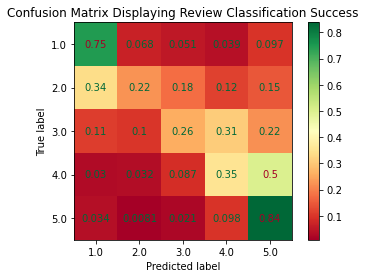

In [22]:
ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize = 'true', cmap = 'RdYlGn')
plt.title('Confusion Matrix Displaying Review Classification Success')
plt.show()

The confusion matrix above shows how successful our logistic regression classification was for each of the five star ratings (1-5). The ideal graph would be all 1 and green on the middle diagonal, meaning that all 1 star ratings were classified as 1, all 2 star ratings were classified as 2, and so on. However, as the confusion matrix shows, the classification was not very successful for the rating numbers 2, 3, and 4. The classifier was fairly good for predicting 1 star ratings (75% accuracy) and 5 star ratings (84% accuracy) which makes sense, because these are most likely skewed by strong language. If strong negative or positive language is used, it is likely that reviewers also associate that strong review with a decisive score (1 or 5). The middle numbers are more difficult to predict because of the subjectivity that each reviewer has when matching a star rating to a text review. The language that one user decides is a 2 star rating may be very different from the language of a different 2 star review, which affects the classifier. 

In the next blocks of code, we play around with a different "relaxed scoring" to try to improve accuracy. By grouping the ratings into three categories, we refine our method of counting classifications that are one star rating away in either direction. In this case, we group ratings of 1 and 2 as "bad", 3 as "okay", and 4 and 5 as "good". As shown below, the accuracy improves relative to strict scoring, but is still not quite as good as the 1 star off method above.

In [23]:
y_test_3cls = ['Bad' if x in [1,2] else ('Okay' if x == 3 else 'Good') for x in y_test]
preds_3cls  = ['Bad' if x in [1,2] else ('Okay' if x == 3 else 'Good') for x in preds]

In [24]:
print("Accuracy According to Relaxed Scoring Scheme: ", sum(np.array([1 if x==y else 0 for x,y in zip(y_test_3cls, preds_3cls)])) / total)

Accuracy According to Relaxed Scoring Scheme:  0.8072727272727273


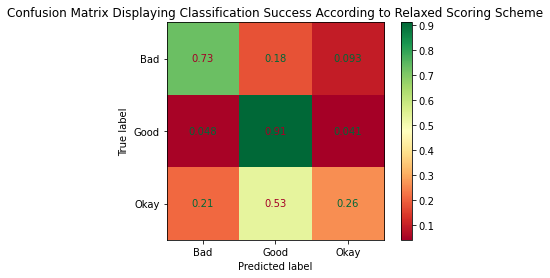

In [25]:
ConfusionMatrixDisplay.from_predictions(y_test_3cls, preds_3cls, normalize = 'true', cmap = 'RdYlGn')
plt.title('Confusion Matrix Displaying Classification Success According to Relaxed Scoring Scheme')
plt.show()

The confusion matrix above shows how successful our logistic regression classification was after creating three groups of ratings.
- The "good" group has the highest accuracy, meaning the classifier was able to identify 4 and 5 star ratings based on the text review very well (91% of the time). This makes sense because positive sentiments more easily and readily align with 4 and 5 star ratings. 
- The accuracy of the "bad" group is not as good, the classifier performed better when just classifying 1 star ratings (see earlier confusion matrix). This is surprising because grouping 4 and 5 star ratings helped, but grouping 1 and 2 star ratings. This seems to be because 4 star ratings are more often confused with 5 star ratings than 2 star ratings are confused with 1 star ratings. This could have to do with the bias in the original dataset, where there are tons of 5 star ratings relative to 2 star ratings (7k vs 1k).
- The "okay" category performs poorly, which makes sense for two reasons. First, because it only includes one star rating (3), there is a smaller successful "target area" that the classifier will succeed in. Second, and to us more insightful, is again the idea that medium reviews are more likely to span different number ratings.

To explore further, we could group 2 and 3 together as "okay" and have 1 star be the "bad" category.


As a final attempt to raise accuracy, below I re-vectorized with max_df initialized to 0.5, to see whether limiting to lemmas present in a maximum of 50% of reviews would provide a better tuned feature matrix.

### Adjusted Vectorizer attempt

In [26]:
## saved this file to avoid rerunning every time

##%%time

### making tf-idf vectorizer with lemmas
##lemma_vectorizer_2 = TfidfVectorizer(
##    input = 'content',
##    encoding = 'utf-8',
##    strip_accents = 'unicode',
##    lowercase = True,
##    tokenizer = lemmatizer,
##    min_df = 0.05,
##    max_df = 0.5,
##    use_idf=True
##)
##
##raw_lemma_2 = lemma_vectorizer_2.fit_transform(reviews['text'])

Wall time: 9min 40s


In [27]:
#with open('X_raw_lemma_2.pickle', 'wb') as f:
#    pickle.dump(raw_lemma_2, f)

In [29]:
raw_lemma_2 = pd.read_pickle(r'X_raw_lemma_2.pickle')

In [30]:
# scaling the vector
scaler = StandardScaler()
scaled_feat_matrix_lemma_2 = scaler.fit_transform(raw_lemma_2.toarray())
print('Shape of feature matrix: ', scaled_feat_matrix_lemma_2.shape)

Shape of feature matrix:  (14997, 225)


This is very smiliar to the size of the last full feature matrix, it simply has 12 fewer columns. This makes me think that perhaps this method may not have actually changed much.

In [31]:
# Classifers to test
classifiers = {
    'Baseline': DummyClassifier(strategy = 'stratified'),
    'kNN': KNeighborsClassifier(),
    'Logit':LogisticRegression(),
    'decisionTree': DecisionTreeClassifier(),
    'randomForest':RandomForestClassifier()
}

scores = {} # Store cross-validation results in a dictionary
for classifier in classifiers: 
    scores[classifier] = cross_validate( # perform cross-validation
        classifiers[classifier], # classifier object
        scaled_feat_matrix_lemma_2, # feature matrix
        y_stars, # gold labels
        cv=10, #number of folds
        scoring=['accuracy','precision_weighted', 'recall_weighted', 'f1_weighted', 'f1_macro', 'f1_micro'] # scoring methods
    )
    
compare_scores(scores)

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_f1_macro,test_f1_micro
Baseline,0.015039,0.018689,0.304261,0.302782,0.304261,0.303410,0.202333,0.304261
kNN,0.020565,1.066254,0.501700,0.425770,0.501700,0.414526,0.267269,0.501700
Logit,1.015093,0.021529,0.609987,0.572022,0.609987,0.582478,0.460732,0.609987
decisionTree,2.924698,0.021045,0.458092,0.454936,0.458092,0.456261,0.347424,0.458092
randomForest,12.992407,0.106603,0.576981,0.499353,0.576981,0.493587,0.335510,0.576981


Unfortunately, accuracy score stayed roughly the same across all classifiers. Limiting to lemmas in 50% of documents did not help!

## Sentiment Score Section

Next, we used sentiment scoring as another method to try improving our classification. While sentiment scoring was something we learned early in the course and were hesitant to use on the final project, we decided to use it because it related so closely to the topic of reviews and associated ratings, which are at their most basic level an expression of feelings. The following few cells build sentiment columns into the existing review dataframe, and calculate average review sentiment using the emolex file we became familiar with during the semester. We take average sentence sentiment, and then average that to get review sentiment.

In [ ]:
#### Adding sentiment score columns
size = len(reviews)

reviews['anger'] = np.zeros(size)
reviews['anticipation'] = np.zeros(size)
reviews['disgust'] = np.zeros(size)
reviews['fear'] = np.zeros(size)
reviews['joy'] = np.zeros(size)
reviews['negative'] = np.zeros(size)
reviews['positive'] = np.zeros(size)
reviews['sadness'] = np.zeros(size)
reviews['surprise'] = np.zeros(size)
reviews['trust'] = np.zeros(size)

In [ ]:
# Making stopwords list
stoplist = stopwords.words('english')
for el in [i for i in string.punctuation]:
    stoplist.append(el)

In [ ]:
# read_emolex function from INFO 3350 problem set code
emolex_file = os.path.join('emolex.txt')

def read_emolex(filepath=None):
    '''
    Takes a file path to the emolex lexicon file.
    Returns a dictionary of emolex sentiment values.
    '''
    if filepath==None: # Try to find the emolex file
        filepath = os.path.join('emolex.txt')
        if os.path.isfile(filepath):
            pass
        elif os.path.isfile('emolex.txt'):
            filepath = 'emolex.txt'
        else:
            raise FileNotFoundError('No EmoLex file found')
    emolex = defaultdict(dict) # Like Counter(), defaultdict eases dictionary creation
    with open(filepath, 'r') as f:
    # emolex file format is: word emotion value
        for line in f:
            word, emotion, value = line.strip().split()
            emolex[word][emotion] = int(value)
    return emolex

# Get EmoLex data. Make sure you set the right file path above.
emolex = read_emolex(emolex_file)

In [ ]:
# tokenize_text from INFO 3350 problem set code
def tokenize_text(text, stops=[]):
    sentences = []
    for sent in sent_tokenize(text.lower()):
        sentences.append([word for word in word_tokenize(sent) if word not in stops])
        
    return sentences

# sentence_sentiment_score from INFO 3350 problem set code
def sentence_sentiment_score(toks, lexicon = emolex):
    total = 0
    emo_dict = defaultdict(lambda: 0)
    
    emotions = ['anger', 'anticipation','disgust','fear','joy','negative','positive','sadness','surprise', 'trust']
    
    
    for word in toks:
            total += 1
            for emotion in emotions:
                try:
                    emo_dict[emotion] += lexicon[word][emotion]
                except:
                    continue
    
    for emotion in emotions:
        if total > 0:
            emo_dict[emotion] /= total
        
    return emo_dict

In [ ]:
def book_sentiment_df_update(sentence_dicts, df, index):
    
    reviewdict = dict({'anger': 0 , 'anticipation': 0,'disgust': 0,'fear': 0,'joy': 0,'negative': 0,'positive': 0,'sadness': 0,'surprise': 0, 'trust': 0})
    
    for sentence_dict in sentence_dicts:
        for emotion in sentence_dict:
            reviewdict[emotion] += sentence_dict[emotion]
    
    for emotion in reviewdict.keys():
        reviewdict[emotion] /= len(sentence_dicts)
        df.at[index, emotion] = reviewdict[emotion]
    
    return None  

In [ ]:
%%time

for index, reviewtext in enumerate(reviews['text']):
    sentence_dicts = []
    for sentence in tokenize_text(reviewtext, stops=stoplist):
        sentence_dicts.append(sentence_sentiment_score(sentence))
    book_sentiment_df_update(sentence_dicts, reviews, index)

In [ ]:
## data frame with sentiment scores added
reviews.head()

In [ ]:
grouped_sent = reviews.groupby(['stars']).mean()\
[['anger','anticipation','disgust','fear','joy','negative','positive','sadness','surprise', 'trust']]

In [ ]:
print("Average Emotion scores of each star rating")
print("Column by Column Coloring: Green Indicates it is the highest value in that column")
grouped_sent.style.background_gradient(cmap='RdYlGn', axis = 0)

The colorful graph above is helpful in understanding how well mean sentiment scores align with star ratings. We were pleasantly surprised by this graph.

This graph is meant to be read column by column. The highest values in each column are colored green, and the lowest colored red.

Looking down the columns for each sentiment, we see just what we would expect:
- The "bad" emotions (anger, disgust, fear, negative, sadness) are on average highest in 1 star ratings and lowest in 5 star ratings. Not only this, but there is a perfect gradient of decreasing average score for these sentiments as you look from 1 star to 5 star ratings. 
- Similarly, for the "good" sentiments (joy, positive, trust), we see the opposite. 5 star ratings have highest average scores, and 1 star ratings have lowest average scores, with perfect gradients.

This graph indicates to us that the sentiment analysis we did worked well on aggregate, and that on average, negative emotions are most associated with 1 star review, and positiove emotions are most associated with 5-star reviews. This gave us hope that our classifiers would do quite well!

In [ ]:
train_df = reviews[['anger','anticipation','disgust','fear','joy','negative','positive','sadness','surprise', 'trust']]

In [ ]:
# Classifers to test
classifiers = {
    'Baseline': DummyClassifier(strategy = 'stratified'),
    'kNN': KNeighborsClassifier(),
    'Logit':LogisticRegression(max_iter = 200),
    'decisionTree': DecisionTreeClassifier(),
    'randomForest':RandomForestClassifier()
}

scores = {} # Store cross-validation results in a dictionary
for classifier in classifiers: 
    scores[classifier] = cross_validate( # perform cross-validation
        classifiers[classifier], # classifier object
        train_df, # feature matrix
        y_stars, # gold labels
        cv=10, #number of folds
        scoring=['accuracy','precision_weighted', 'recall_weighted', 'f1_weighted', 'f1_macro', 'f1_micro'] # scoring methods
    )
    
compare_scores(scores)

### Accuracy and f1 scores were worse across the board relative to when we used the same classifiers with a tfidf lemma matrix.
This method resulted in just a 20% lift above baseline accuracy for the best performing algorithm, the Logit classifier. We moved on to looking at a relaxed scoring scheme and confusion matrix for more insight into why.

In [ ]:
LogReg= LogisticRegression(max_iter=200)
X_train, X_test, y_train, y_test = train_test_split(train_df, y_stars, test_size=0.33, random_state=42)
LogReg.fit(X_train, y_train)
preds = LogReg.predict(X_test)

In [ ]:
count_within1 = 0
for x,y in zip(preds, y_test):
    if(abs(x-y) <= 1): count_within1 +=1

print('Predictions that were correct or 1 star off: ', count_within1, '/', total, 'or ', round((count_within1/total) * 100, 2), '%')

The 1-star off scoring method improved accuracy score by a lot again, but it is still 15% lower than it was with the tfidf lemma feature matrix.

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize = 'true', cmap = 'RdYlGn')
plt.title('Confusion Matrix Displaying Classification Success')
plt.show()

In [ ]:
y_test_3cls = ['Bad' if x in [1,2] else ('Okay' if x == 3 else 'Good') for x in y_test]
preds_3cls  = ['Bad' if x in [1,2] else ('Okay' if x == 3 else 'Good') for x in preds]
print("Accuracy According to Relaxed Scoring Scheme: ", sum(np.array([1 if x==y else 0 for x,y in zip(y_test_3cls, preds_3cls)])) / total)
ConfusionMatrixDisplay.from_predictions(y_test_3cls, preds_3cls, normalize = 'true', cmap = 'RdYlGn')
plt.title('Confusion Matrix Displaying Classification Success According to Relaxed Scoring Scheme')
plt.show()

As mentioned above, because we had a well-aligned average sentiment score by star-rating chart, we thought using average review sentiment score would result in more successful classification. However, the above scores revealed that did not turn out to be the case. The two confusion matrices above, using two different scoring schemes, begin to show us why sentiment score did not perform well.

The main conclusion here is that an overwhelming majority of reviews were being classified as 5 star, a few as 1 star, and none/almost none as 2, 3, or 4 stars. 

We believe the main reason 5 star reviews were so overrepresented in the predictions is because the 5 star reviews are over represented in the original dataset; almost half of the 15k reviews (7k) were 5-star.

That being said, the same was true in the tfidf lemma feature matrix which performed much better, so we knew there must be another reason.

After some thought, we realized that a lack of sentiment in many reviews could have resulted in a non-informative feature matrix, which made the algorithms so suscpetible to the bias in the initial set of reviews. While avergae sentiment across 1-5 star reviews was informative, individual reviews may not have had much sentiment. If there are only a couple of emotions scored per review, the classifier will not have enough information to properly asses each review. The averages may have clouded this aspect of the data, and the averages could have been skewed by some very aggressively positive or negative reviews at either end of the spectrum.

Below, we look at the negativity and positive scores of the most negative and most positive reviews, and select the text from one of them.

In [ ]:
reviews['negative'].nlargest(n=3)

In [ ]:
reviews['positive'].nlargest(n=3)

In [ ]:
reviews.iloc[6346].text, reviews.iloc[146].positive

The highest average positivity score was around 0.15 for 5-star reviews, and the highest average negativity score was around 0.08 for 1-star reviews. The positivity and negativity scores above confirm our suspicion that some very positive and negative reviews may have skewing the avergaes, which gave us hope for good classification performance. The example text and positivity score shows how this could happen; short reviews and sentences with a high concentration of positive words gives very high average positivity.

Below, we look at some more informative statistics on the distribution of sentiment scores.

In [ ]:
train_df.describe()

This chart above shows that sentiment scores across all reviews are dominated by scores of zero in many cases, and in other cases have slightly fewer zeros but tiny standard deviations. The dominance of completely uninformative zeros in the dataset, paired with very small variation in scores that are nonzero makes us think that these characteristics made the feature matrix poor, resulting in low accuracy scores across all classifiers.

Below, I implement word embeddings, which are sort of a more complex version of sentiment analysis. They turn each word into a 300 component long vector, and then average the words in each review to get the mean review for the vector. I am hoping that the larger number of compoenents in embeddings relative to the above sentiment analysis (300 vs 10) will help accuracy.

# Embedding attempt

In [ ]:
#Helper functions from p_08 answer key

# Function(s) to calculate embeddings from text
def remove_noninformative_tokens(doc):
    '''
    Takes a spacy-processed document.
    Returns a list of spacy token objects without stopwords, punctuation, or embedding-less tokens.
    '''
    culled = [token for token in doc if not (token.is_stop or token.is_punct or token.is_space) and token.has_vector]
    return(culled)

def get_doc_embedding(text, nlp):
    '''
    Takes a document as a text string and a loaded spaCy nlp object.
    Returns a vector representation of the document.
    '''
    doc = nlp(text)
    culled = remove_noninformative_tokens(doc)
    embedding = np.mean([token.vector for token in culled], axis=0)
    if np.isnan(embedding).any():
        embedding = np.zeros([1,nlp.vocab.vectors_length])
        print(f"There was a problem with document {i}\nText: {text}\n")
    return(embedding)

In [ ]:
## This was run once and then commented out because after creating the embeddings, we saved the file to avoid running this cell again,
## because it takes a while to run.


### %%time
### # Vectorize embeddings
### import spacy
### import datetime
### nlp = spacy.load("en_core_web_lg")
### 
### X_embed = np.zeros([len(reviews), nlp.vocab.vectors_length])
### for i, text in enumerate(reviews.text):
###     if i%1000 == 0:
###         print(f'{i:<5} documents processed @ {datetime.datetime.now()}')
###     X_embed[i] = get_doc_embedding(text, nlp)
### print(X_embed.shape)

In [ ]:
##with open('X_embed.pickle', 'wb') as f:
##    pickle.dump(X_embed, f)

In [ ]:
X_embed = pd.read_pickle(r'X_embed.pickle')

In [ ]:
# Classifers to test
classifiers = {
    'Baseline': DummyClassifier(strategy = 'stratified'),
    'kNN': KNeighborsClassifier(),
    'Logit':LogisticRegression(max_iter = 500),
    'decisionTree': DecisionTreeClassifier(),
    'randomForest':RandomForestClassifier()
}

scores = {} # Store cross-validation results in a dictionary
for classifier in classifiers:
    print(f'{classifier} starting @ {datetime.datetime.now()}')
    scores[classifier] = cross_validate( # perform cross-validation
        classifiers[classifier], # classifier object
        X_embed, # feature matrix
        y_stars, # gold labels
        cv=10, #number of folds
        scoring=['accuracy','precision_weighted', 'recall_weighted', 'f1_weighted', 'f1_macro', 'f1_micro'] # scoring methods
    )
    
compare_scores(scores)

## Here we see that word embeddings resuted in improved accuracy and f1 across the board. Logit still scored the best, with an accuracy of 63.9% the best accuracy we have seen thus far!

Though it is only a small lift over the tfidf lemma matrix, it is a large increase relative to averaged sentence sentiment. Below, please see the relaxed scoring methods we have used for other feature matrices again.

In [ ]:
# train test split of the full feature matrix
LogReg= LogisticRegression(max_iter = 500)

X_train, X_test, y_train, y_test = train_test_split(X_embed, y_stars, test_size=0.33, random_state=42)
LogReg.fit(X_train, y_train)
preds = LogReg.predict(X_test)
print('Correct Predictions: ', accuracy_score(y_test, preds), '= 64.2%')

count_within1 = 0
for x,y in zip(preds, y_test):
    if(abs(x-y) <= 1): count_within1 +=1
    
total = len(preds)

print('Predictions that were correct or 1 star off: ', count_within1, '/', total, 'or ', round((count_within1/total) * 100, 2), '%')

y_test_3cls = ['Bad' if x in [1,2] else ('Okay' if x == 3 else 'Good') for x in y_test]
preds_3cls  = ['Bad' if x in [1,2] else ('Okay' if x == 3 else 'Good') for x in preds]
print("Accuracy According to Relaxed 3-class Scoring Scheme: ", round(sum(np.array([1 if x==y else 0 for x,y in zip(y_test_3cls, preds_3cls)])) / total, 4)*100, '%')

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize = 'true', cmap = 'RdYlGn')
plt.title('Confusion Matrix Displaying Review Classification Success')
plt.show()

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_3cls, preds_3cls, normalize = 'true', cmap = 'RdYlGn')
plt.title('Confusion Matrix Displaying Classification Success According to Relaxed Scoring Scheme')
plt.show()

Across the board, we see very similar patterns to what we saw with the tfidf lemma matrix, with slightly elevated accuracy. Some interesting things to note:

- Though embeddings had higher overall accuracy, more 2-star ratings were confused with 1-star ratings (0.38 v 0.34), and more 4-star ratings were confused with 5-star ratings(0.57 v 0.5), than with tfidf lemma matrix. 
- Emeddings did slightly worse overall with 2, 3, and 4 star ratings than the tfidf lemma matrix (0.18, 0.26, 0.32 v 0.22, 0.26, 0.35).
- Embeddings more than made up for this by more accuractely classifying 1 and 5 star ratings better than tfidf lemma (0.82 v 0.75 and 0.87 v 0.84) resulting in higher overall accuracy, because there are so many 5 star ratings in particular.

## Business type topic models

In [ ]:
combined.columns

In [ ]:
combined = combined.drop(['useful','cool','date','funny','latitude','longitude','stars_y','is_open','hours'], axis=1)
#combined.columns

In [ ]:
main_cat = []

for category in combined['categories']:
    cat = category.split(',')[0]
    main_cat.append(cat)
    
combined['category'] = main_cat
#combined.columns

In [ ]:
# baseline accuracy, fraction of businesses that are restaurants

baseline = len(combined[combined['category'].str.contains('Restaurants')]) / len(combined)
print('Baseline accuracy for restaurants in the data:', baseline)

In [ ]:
# binary list -- yes or no restaurant
countrest = []

for category in combined['category']:
    if category == 'Restaurants':
        countrest.append(1)
    else:
        countrest.append(0)

# add binary restaurant column
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    combined['restaurant'] = countrest

In [ ]:
vectorizer_w = CountVectorizer( 
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    stop_words= stoplist, 
    lowercase = True,
    min_df = 0.01, 
    max_df = 0.5 
)

X_w = vectorizer_w.fit_transform(combined['text'])
print("Feature matrix shape, all reviews:", X_w.shape)

In [ ]:
lda_w = LatentDirichletAllocation(
    n_components=50, 
    n_jobs=-1,     
    max_iter=10
)

lda_w.fit(X_w)

In [ ]:
# doc topic matrix
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    doc_topic_matrix_w = lda_w.transform(X_w)
print("All reviews doc-topic matrix shape:", doc_topic_matrix_w.shape)

In [ ]:
## From lecture 20-21

def print_top_words(model, feature_names, n_top_words, hide_stops=False):
    if hide_stops:
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic {topic_idx: >2}: "
        top_words_idx = topic.argsort()
        if not hide_stops:
            top_words = [feature_names[i]
                         for i in top_words_idx[:-n_top_words - 1:-1]]
        else:
            top_words = []
            i = 1
            while len(top_words) < n_top_words:
                if feature_names[top_words_idx[-i]] not in ENGLISH_STOP_WORDS:
                    top_words.append(feature_names[top_words_idx[-i]])
                i += 1
        message += " ".join(top_words)    
        print(message)
    print()

In [ ]:
print('50 topics from the entire dataset \n')
print_top_words(lda_w, vectorizer_w.get_feature_names_out(), n_top_words=10, hide_stops=False)

In [ ]:
# Correlation plot -- lecture 20-21
# Adapted from Seaborn docs
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from   sklearn.preprocessing import StandardScaler

#sns.set_context('talk')
corr = np.corrcoef(doc_topic_matrix_w.T)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask, 
    cmap=cmap, 
    center=0,
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .5}
)
plt.tight_layout()
plt.show()

#### The heat map above shows the correlation between each topic in the topic matrix. The fact that we used 50 topics in the model makes the graph a bit difficult to read, but there are a few "hot spots" of blue and red that indicate interesting correlations between two topics.

#### Positive correlations
- 32 and 43
- 33 and 43
- 4 and 31

--- 

Topic  4: sandwich burger good fries like burgers really would one got

Topic 31: cheese sauce steak mac bbq meat ribs onions dry sauces

***Both of these topics involve meat and make us think of classic "American" food.***

---

Topic 32: service customer phone call called would time work delivery arrived

Topic 43: would us told company said day called card back credit

***These topics hint at calling and customer service.***

---

Topic 33: car back would review get reviews since another still

Topic 43: would us told company said day called card back credit

***These topics are somewhat of a mystery but also hint at customer service.***

---

#### Negative correlations 
- 17 and 48
- 17 and 41
- 17 and 42

***Topic 17 had the most strong negative correlations based on the graph (most dark red squares in the 17 column)***

---

Topic 17: great good food service drinks bar atmosphere place friendly go

Topic 41: said asked back like get rude time manager could one

***These are opposite experiences of good vs bad customer service.***

---

Topic 17: great good food service drinks bar atmosphere place friendly go

Topic 42: help time like care thank store questions made helped 

***When reading these, they both signal good experiences for customers, so this is an unexpected negative correlation. However, Topic 17 has a specific place associated with it (drinks, bar, etc.), so that may be where the negative correlation stems from.***

--- 

Topic 17: great good food service drinks bar atmosphere place friendly go

Topic 48: would could told even one thought experience make get give

***The jumble of words from 48 may signify that incoherence skews the topics and therefore these are different for an inexplicable reason by humans.***

#### Below we scale the topic matrix so that it can be passed into multiple classifiers to find the best performance.

In [ ]:
# make topic matrix
X_w_topics = StandardScaler().fit_transform(doc_topic_matrix_w)

In [ ]:
# Classifers to test
classifiers = {
    'Baseline': DummyClassifier(strategy = 'stratified'),
    'kNN': KNeighborsClassifier(),
    'Logit':LogisticRegression(),
    'decisionTree': DecisionTreeClassifier(),
    'randomForest':RandomForestClassifier()
}

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    scores = {} 
    for classifier in classifiers: 
        scores[classifier] = cross_validate(
            classifiers[classifier], 
            X_w_topics,
            countrest, 
            cv=10, 
            scoring=['accuracy','precision_weighted', 'recall_weighted', 'f1_weighted', 'f1_macro', 'f1_micro']
        )
    
compare_scores(scores)

Using the topic modeling, we can see that classifying whether a business is a restaurant or not based on the topic matrix performs relatively well, and definitely better than the baseline. The chart shows us that our highest performing classifier, Logistic Regression, has F1 = 0.75 and accuracy = 0.82.

This realtively good performance makes sense because many of the topics (printed above) have specific food related words in the reviews that make it more apparent that it is a restaurant. It seems reasonable that the performance is not higher, though, because some of the topics contain generally applicable words such as "good", "service", "like", "bad", "love", and "wait", to name a few. These words skew the relevance of topics to be applicable to all businesses, making it more difficult to differentiate between a restaurant or not.

#### Below, we try to improve classification by changing the number of topics. We hypothesized that adding more topics would improve the classification because the topic model would would become more specific and possibly provide more restaurant-specific topics.

In [ ]:
lda_w_100 = LatentDirichletAllocation(
    n_components=100, 
    n_jobs=-1,     
    max_iter=10
)

lda_w_100.fit(X_w)

In [ ]:
# doc topic matrix
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    doc_topic_matrix_100 = lda_w_100.transform(X_w)
print("Doc-topic matrix of whole dataset shape:", doc_topic_matrix_100.shape)

In [ ]:
X_w_100 = StandardScaler().fit_transform(doc_topic_matrix_100)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    scores2 = {} # Store cross-validation results in a dictionary
    for classifier in classifiers: 
        scores2[classifier] = cross_validate(
            classifiers[classifier], 
            X_w_100, 
            countrest, 
            cv=10, 
            scoring=['accuracy','precision_weighted', 'recall_weighted', 'f1_weighted', 'f1_macro', 'f1_micro']
        )
    
compare_scores(scores2)

#### Adding more topics basically did not change any of the classification outputs. We also tried with 10 and 500 topics (not shown), and there was still no change. This was unexpected because we thought more topics would provide more restaurant-specific information. These results probably reflect the number of reviews that are general ("good", "service", "bad", etc.). 

#### From here, we were curious about the topic model for only restaurants. Would the topcis be more restaurant specific?

We decided to narrow down the dataset to just restaurants and then classify into different types of restaurants with a topic model of the new restaurant dataset. We hypothesized that topics of the reviews of only restaurants would include cuisine-specific words. Based on the prevalence of these topics in different reviews, the classifier would perform well for deciding if a review was for a certain type of restaurant or not.

In [ ]:
restaurant_df = pd.DataFrame(combined[combined['category'].str.contains('Restaurants')])
restaurant_df.head()

In [ ]:
# use this to get an idea of the categories we'll make
restaurant_df['categories'].value_counts()[0:10]

#### The list above shows the top "sub-categories" amongst the restaurant reviews. We will use this to inform our top five cuisine types that we will perform classification on using topic modeling of the restaurant dataset. 

#### Based on the list, our multiclass classification gold labels will be Mexican (1), Pizza (2), Chinese (3), Italian (4), American (5, combining New and Traditional), and other (6). 

In [ ]:
# make column with cuisine
cuisine = []

for category in restaurant_df['categories']:
    cat = category.split(',')
    if (len(cat) > 1):
        cat = category.split(',')[1]
        cat = cat[1:]
        cuisine.append(cat)
    else:
        cuisine.append('N/A')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    restaurant_df['cuisine'] = cuisine

#restaurant_df.head()

In [ ]:
# add numbers associated with each cuisine to dataframe
y_cuisine = []

for cuisine in restaurant_df['cuisine']:
    if cuisine == 'Mexican':
        y_cuisine.append(1)
    elif cuisine == 'Pizza':
        y_cuisine.append(2)
    elif cuisine == 'Chinese':
        y_cuisine.append(3)
    elif cuisine == 'Italian':
        y_cuisine.append(4)
    elif cuisine == 'American (New)' or cuisine == 'American (Traditional)':
        y_cuisine.append(5)
    else:
        y_cuisine.append(6)
        
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    restaurant_df['y_cuisine'] = y_cuisine
    
#restaurant_df.head(10)

In [ ]:
vectorizer_r = CountVectorizer( 
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    stop_words= stoplist, 
    lowercase = True,
    min_df = 0.01, 
    max_df = 0.5 
)

X_r = vectorizer_r.fit_transform(restaurant_df['text'])
print("Feature matrix shape, restaurant reviews:", X_r.shape)

In [ ]:
lda_r = LatentDirichletAllocation(
    n_components=50, 
    n_jobs=-1,     
    max_iter=10
)

lda_r.fit(X_r)

In [ ]:
# doc topic matrix
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    doc_topic_matrix = lda_r.transform(X_r)
print("Restaurant reviews doc-topic matrix shape:", doc_topic_matrix.shape)

In [ ]:
print('50 topics from the entire dataset \n')
print_top_words(lda_r, vectorizer_r.get_feature_names_out(), n_top_words=10, hide_stops=False)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    scores3 = {}
    for classifier in classifiers: 
        scores3[classifier] = cross_validate(
            classifiers[classifier],
            X_topics, 
            y_cuisine,
            cv=10, 
            scoring=['accuracy','precision_weighted', 'recall_weighted', 'f1_weighted', 'f1_macro', 'f1_micro']
        )
        
compare_scores(scores3)

#### It makes sense that this subset performed worse than the "restaurant vs other" classifier because adding more categories makes prediction more difficult. Additionally, given what we know about the general topics of many reviews and even the overlap of different food-specific words (e.g., "sauce" could apply to Pizza and Mexican), it is actually surprising that the classifier did so well.

#### The chart above shows the classification performance for four different classifiers compared to the baseline multiclass classification. Since Random Forest performed the best, we will change some parameters to try and improve the performance.

In [ ]:
## trying to improve the random forest
RFfeatures = {
    'feature_None':RandomForestClassifier(max_features=None),
    'feature_50':RandomForestClassifier(max_features=50),
    'feature_10':RandomForestClassifier(max_features=10),
    'feature_5':RandomForestClassifier(max_features=10),
    'feature_2':RandomForestClassifier(max_features=2)
}

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    RFscores = {} 
    for classifier in RFfeatures:
        RFscores[classifier] = cross_validate( 
            RFfeatures[classifier], 
            X_topics, 
            y_cuisine, 
            cv=10, 
            scoring=['accuracy','precision_weighted', 'recall_weighted', 'f1_weighted', 'f1_macro', 'f1_micro']
        )

compare_scores(RFscores)

#### Here we see that the Random Forest Classifier with 5 max features, meaning the classifier can only try up to five features per node (i.e., the number of options to consider for classification).

#### From a baseline F1 of 0.51 to our best F1 of 0.60, a 0.10 increase is not bad! Additionally, the accuracy increased by almost 0.20.

#### Our final test is to see how classifiers perform on a binary ***within*** the restaurant subset. Can we determine if a restaurant is Mexican or not based on topic modeling?

In [ ]:
# make binary columnn for Mexican gold labels
y_mex = []

for cuisine in restaurant_df['cuisine']:
    if cuisine == 'Mexican':
        y_mex.append(1)
    else:
        y_mex.append(0)
        
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    restaurant_df['mexican'] = y_mex
    
#restaurant_df.head()

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    scores4 = {}
    for classifier in classifiers: 
        scores4[classifier] = cross_validate(
            classifiers[classifier],
            X_topics, 
            y_mex,
            cv=10, 
            scoring=['accuracy','precision_weighted', 'recall_weighted', 'f1_weighted', 'f1_macro', 'f1_micro']
        )
        
compare_scores(scores4)

#### Classifying cuisines as a binary performs very well! 

This makes sense because in the document topic matrix for only restaurants, the weight that cuisine-specific topics have (Topic 29: taco good prices bit really large got order restaurant big) makes the cuisine-specific reviews stand out to the classifier. While it is gratifying to have a classifier perform so well, we recognize that this is not the most challenging task and does not provide much new insight.

# 3. Results Summary

In terms of our first two questions regarding what algorithms and feature matrices were most effective for using review text to predict star ratings, we found that Logistic Regression was the most effective algorithm across all feature matrices, with Random Forest in second. Decision Tree and K Nearest Neighbors were both further behind. Additionally we found that a tfidf lemma feature matrix resulted in much better accuracy than an average review sentiment feature matrix. As discussed above, many reviews lacked enough sentiment across each emotion to inform the classifiers enough, resulting in a strong bias towards 5-star reviews, the most common review in the dataset. Finally, we tried to fix that issue by using word embeddings. This resulted in the highest accuracy yet, around 64%, or a 34% lift over baseline accuracy. This was because the word embeddings included a lot of sensitivity and information per word, making up for the shortcomings of the more simple sentiment analysis.

For algorithms and topic modeling, we found that Logistic Regression was the most effective for predicting whether a review was for a restaurant or not when applied to the entire dataset. When moving into the restaurant subset of the data, we found that the Random Forest algorithm with max_features = 5 performed the best for our multiclass question of cuisine prediction (Mexican, Pizza, Chinese, Italian, American, Other). Finally, we explored the performance of a binary cuisine question within the restaurant subset (Mexican vs Other) based on topic modeling and found this to be overall the most successful, which makes sense because cuisine-specific words would improve the classification for one specific type of cuisine (as opposed to choosing one of six, as with the multiclass question).

#### Topic Model Final Improvement: Restaurant vs Not Restaurant review in entire dataset

In [ ]:
# Classifers to test
classifiers1 = {
    'Baseline': DummyClassifier(strategy = 'stratified'),
    'Logit':LogisticRegression()
}

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    scores11 = {} 
    for classifier in classifiers1: 
        scores11[classifier] = cross_validate(
            classifiers1[classifier], 
            X_w_topics,
            countrest, 
            cv=10, 
            scoring=['accuracy','precision_weighted', 'recall_weighted', 'f1_weighted']
        )
    
compare_scores(scores11)

#### Topic Model Final Improvement: Multiclass cuisine in restaurant subset

In [ ]:
# Classifers to test
classifiers2 = {
    'Baseline': DummyClassifier(strategy = 'stratified'),
    'randomForest': RandomForestClassifier(max_features=5)
}

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    scores12 = {} 
    for classifier in classifiers2: 
        scores12[classifier] = cross_validate(
            classifiers2[classifier], 
            X_topics,
            y_cuisine, 
            cv=10, 
            scoring=['accuracy','precision_weighted', 'recall_weighted', 'f1_weighted']
        )
    
compare_scores(scores12)

#### Topic Model Final Improvement: Binary cuisine (Mexican vs Not) in restaurant subset

In [ ]:
# Classifers to test
classifiers3 = {
    'Baseline': DummyClassifier(strategy = 'stratified'),
    'randomForest': RandomForestClassifier()
}

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    scores13 = {} 
    for classifier in classifiers3: 
        scores13[classifier] = cross_validate(
            classifiers3[classifier], 
            X_topics,
            y_mex, 
            cv=10, 
            scoring=['accuracy','precision_weighted', 'recall_weighted', 'f1_weighted']
        )
    
compare_scores(scores13)

# 4. Discussion & Conclusion

In conclusion, both tfidf lemma and sentiment scored feature matrices resulted in varying lift above baseline accuracy. Sentiment scoring however was not particularly effective, and was limited by a lack of some emotions detected in many reviews. Perhaps a more finely tuned approach such as word embeddings would better capture the meaning and emotion of each sentence, and result in higher accuracy; the limitation to ten emotions could be part of the reason why sentiment scoring was not working well. We overcame this limitation by using word embeddings, to achieve our highest ever accuracy. That being said, word embeddings are not without limitations. They average the whole sentence, which may dampen or overrepresent some strong emotions in the dataset. Using features that include more information on the actual range of scores along each reviews 300 component averaged vector. This could improve accuracy. Another general limitation had to do with the dataset itself. There were many more 5-star reviews than any other type of review, which may have biased the dataset. While balancing classes might have reduced bias, it might have also reduced accuracy scores; in some ways the bias of the dataset was useful for the classifiers, because it reflected a real tendency in the data that then became built into the classifiers.

Topic modeling was a successful way to classify different aspects of the dataset, including whether or not a review was for a restaurant, what type of cuisine a restaurant was, and if a restaurant was Mexican or not. Using topic modeling made sense because we hypothesized that the topics would reveal specific information about these various questions based on the specific words in each topic.

There were some limitations with the topic modeling because of the setup of the original data. The original "categories" column was an English list (not a list type) that separated each category of the business with a comma. Additionally, the list for each business was not in any priority otder, so, for example, some businesses had "Restaurants" listed first, while other had it listed third or fourth. Retrieving this information required some string maneuvering which led us to the decision that we would only deal with the first and second listed categories of each review. This means we probably lost some reviews that could have been counted as restaurants and then further within the cuisines we chose to analyze. Another limitation was the repetition of words that could have been lemmatized. We also could have updated our list of stopwords specifically for the restaurant reviews to get more targeted and meaningful results, because we saw the repetition of many general words such as "like", "good", "bad", etc.

Overall, this was a fun exploration of Yelp reviews. This project was enjoyable because we had the freedom to apply what we learned on longer novels and literature to shorter, modern text. This project showed us how useful the tools from this class can be for current data sources, as well as historical ones.